In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [3]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [4]:
def Rabi(Fg, Fe, mg, me, Jg, Je, I, omega_0, tau, pol):
    q = -(me-mg)
    Jg_d_Je = __Jg_d_Je(omega_0, Jg, Je, tau)
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus *
        (-1)**(Fe+Jg+1+I) * np.sqrt( (2*Fe+1)*(2*Jg+1) ) * CG_coeff * 
        float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
    )

In [5]:
def cos_fit(t, f, phi):
    return -np.cos(2*np.pi*t*f+phi)*1/2+1/2

In [6]:
_lambda = 1389e-9
m = 171*u
omega_0 =  2*np.pi*c/_lambda
#https://journals.aps.org/pra/pdf/10.1103/PhysRevA.100.042505
gamma = 2*np.pi*308e3
tau = 1/gamma

In [7]:
Fg = 1/2
Je = 1
Jg = 0
I = 1/2
Le = 2
Se = 1

Fe_12 = 1/2
Fe_32 = 3/2

In [8]:
one = basis(8,0) #1S0 mF=-1/2
two = basis(8,1) #1S0 mF=+1/2
three = basis(8,2) #F=1/2 3P1 mF=-1/2
four = basis(8,3) #F=1/2 3P1 mF=+1/2
five = basis(8,4) #F=3/2 3P1 mF=-3/2
six = basis(8,5) #F=3/2 3P1 mF=-1/2
seven = basis(8, 6) #F=3/2 3P1 mF=+1/2
eight = basis(8, 7) #F=3/2 3P1 mF=+3/2

sig_11 = one*one.dag()
sig_22 = two*two.dag()
sig_33 = three*three.dag()
sig_44 = four*four.dag()
sig_55 = five*five.dag()
sig_66 = six*six.dag()
sig_77 = seven*seven.dag()
sig_88 = eight*eight.dag()


#connections from 1S0 mF=-1/2
sig_13 = one*three.dag()
sig_31 = three*one.dag()

sig_14 = one*four.dag()
sig_41 = four*one.dag()

sig_51 = five*one.dag()
sig_15 = one*five.dag()

sig_61 = six*one.dag()
sig_16 = one*six.dag()

sig_71 = seven*one.dag()
sig_17 = one*seven.dag()


#connections from 1S0 mF=+1/2
sig_23 = two*three.dag()
sig_32 = three*two.dag()

sig_24 = two*four.dag()
sig_42 = four*two.dag()

sig_62 = six*two.dag()
sig_26 = two*six.dag()

sig_72 = seven*two.dag()
sig_27 = two*seven.dag()

sig_82 = eight*two.dag()
sig_28 = two*eight.dag()

In [9]:
psi0 = two

## As a function of polarization purity

In [10]:
#Zeeman shifts

B = 1*1e-4

gJe = 3/2 + (Se*(Se+1) - Le*(Le+1)) / 2 / Je / (Je+1)  
gFe_12 = (Fe_12*(Fe_12+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_12 / (Fe_12+1) * gJe
gFe_32 = (Fe_32*(Fe_32+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_32 / (Fe_32+1) * gJe

B = 1*1e-4

delta_N = -2*np.pi*750*B #nuclear states splitting

Delta_g1 = -delta_N/2
Delta_g2 = delta_N/2

Delta_e3 = -1/2*gFe_12*mB*B / hbar
Delta_e4 = 1/2*gFe_12*mB*B / hbar
Delta_e5 = -3/2*gFe_32*mB*B / hbar
Delta_e6 = -1/2*gFe_32*mB*B / hbar
Delta_e7 = 1/2*gFe_32*mB*B / hbar
Delta_e8 = 3/2*gFe_32*mB*B / hbar

In [23]:
Delta_12 = 2*np.pi*10e9 #detuning from the free space resonance of F=1/2
Delta_32 = Delta_12+2*np.pi*(4.082-1.019)*1e9 #detuning from the free space resonance of F=3/2

In [24]:
#diagonal terms
diag_1 = Delta_g1
diag_2 = Delta_g2

diag_3 = -Delta_12 + Delta_e3
diag_4 = -Delta_12 + Delta_e4

diag_5 = -Delta_32 + Delta_e5
diag_6 = -Delta_32 + Delta_e6
diag_7 = -Delta_32 + Delta_e7
diag_8 = -Delta_32 + Delta_e8

In [28]:
phi_ls = np.linspace(np.pi/4, 3*np.pi/4, 20)

#phi_ls = [np.pi/2]

#total intensity at the atom
wV = 0.055e-3
wH = 1.3e-3
Ptot = 10e-3
intensity = 2*Ptot/np.pi/wV/wH


f_ls = []

output_ls = []

ttot_ls = []

xrot_err_ls = []

for phi in phi_ls:


    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = 1/np.sqrt(2)*(y+np.exp(-1j*phi)*z)

    #spherical tensor
    pi_pol = y
    sigp_pol = 1/np.sqrt(2)*(z-1j*x)
    sigm_pol = -1/np.sqrt(2)*(z+1j*x)
    
    #off-diagonal terms
    offdiag_31 = Rabi(Fg, Fe_12, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_41 = Rabi(Fg, Fe_12, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    offdiag_32 = Rabi(Fg, Fe_12, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_42 = Rabi(Fg, Fe_12, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2

    offdiag_51 = Rabi(Fg, Fe_32, -1/2, -3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_61 = Rabi(Fg, Fe_32, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_71 = Rabi(Fg, Fe_32, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    
    offdiag_62 = Rabi(Fg, Fe_32, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_72 = Rabi(Fg, Fe_32, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_82 = Rabi(Fg, Fe_32, 1/2, 3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2

    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_14 = np.conjugate(offdiag_41)
    offdiag_23 = np.conjugate(offdiag_32)
    offdiag_24 = np.conjugate(offdiag_42)

    offdiag_15 = np.conjugate(offdiag_51)
    offdiag_16 = np.conjugate(offdiag_61)
    offdiag_17 = np.conjugate(offdiag_71)
    
    offdiag_26 = np.conjugate(offdiag_62)
    offdiag_27 = np.conjugate(offdiag_72)
    offdiag_28 = np.conjugate(offdiag_82)

    Hdiag = (diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44 
             + diag_5*sig_55 + diag_6*sig_66 + diag_7*sig_77 + diag_8*sig_88)
    
    Hoffdiag = (    offdiag_13*sig_13 + offdiag_31*sig_31
                  + offdiag_14*sig_14 + offdiag_41*sig_41
    
                  + offdiag_23*sig_23 + offdiag_32*sig_32
                  + offdiag_24*sig_24 + offdiag_42*sig_42
    
                  + offdiag_15*sig_15 + offdiag_51*sig_51
                  + offdiag_16*sig_16 + offdiag_61*sig_61
                  + offdiag_17*sig_17 + offdiag_71*sig_71
    
                  + offdiag_62*sig_62 + offdiag_26*sig_26
                  + offdiag_72*sig_72 + offdiag_27*sig_27
                  + offdiag_82*sig_82 + offdiag_28*sig_28 )

    H = Hdiag + Hoffdiag
    guess=np.sqrt((abs(offdiag_31*offdiag_41)*np.sin(phi)/Delta_12)**2)
    c_ops = []
    
    options = qutip.solver.Options(nsteps=1000000)
    m=500
    tf = 1./guess
    dt = tf/m
    t_ls = np.arange(0, tf, dt)
    
    ttot_ls.append(t_ls)
    
    output = mesolve(H, psi0, t_ls, c_ops, [sig_11], options=options)
    output_ls.append(output)
    
    popt, pcov = curve_fit(cos_fit, t_ls, output.expect[0], p0=[guess, -np.pi/2])
    
    f_ls.append(popt[0])
    
    xrot_err_ls.append(1-max(output.expect[0]))

1.1361961458633683


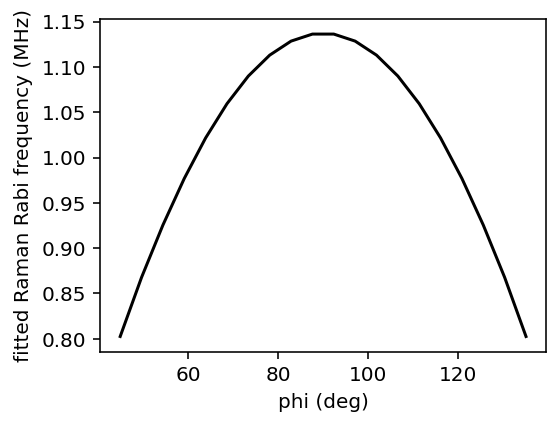

In [29]:
plt.figure(dpi=144, figsize=(4,3))

plt.plot(phi_ls/np.pi*180, np.array(f_ls)/1e6, 'k-')
plt.xlabel('phi (deg)')
plt.ylabel('fitted Raman Rabi frequency (MHz)')
plt.ylim()
print(max(f_ls)/1e6)

3.1759448766364784


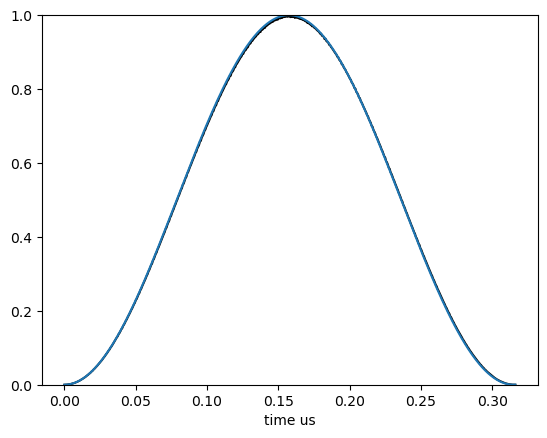

In [64]:
n=5

plt.plot(ttot_ls[n]*1e6, output_ls[n].expect[0], 'k')
plt.plot(ttot_ls[n]*1e6, cos_fit(ttot_ls[n], f_ls[n], 0))
plt.xlabel('time us')
plt.ylim(0, 1)

print(f_ls[n]/1e6)

(0.0, 0.01)

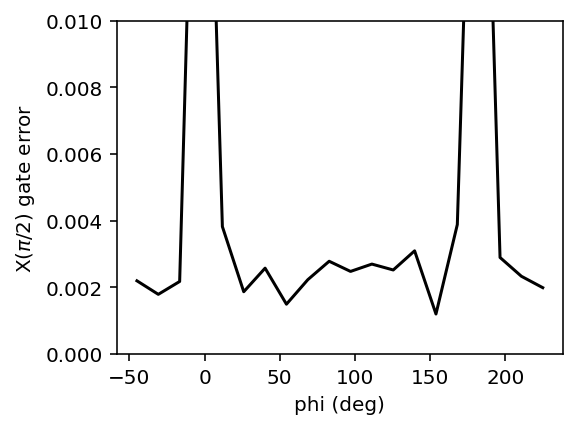

In [65]:
plt.figure(dpi=144, figsize=(4,3))

plt.plot(phi_ls/np.pi*180, np.array(xrot_err_ls), 'k-')
plt.xlabel('phi (deg)')
plt.ylabel('X($\pi$/2) gate error')
plt.ylim(0, 1e-2)

## As a function of Rabi frequency

In [66]:
#Zeeman shifts

B = 4.8*6.8*1e-4

gJe = 3/2 + (Se*(Se+1) - Le*(Le+1)) / 2 / Je / (Je+1)  
gFe_12 = (Fe_12*(Fe_12+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_12 / (Fe_12+1) * gJe
gFe_32 = (Fe_32*(Fe_32+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_32 / (Fe_32+1) * gJe

B = (6.8*4.8)*1e-4

delta_N = -2*np.pi*750*B #nuclear states splitting

Delta_g1 = -delta_N/2
Delta_g2 = delta_N/2

Delta_e3 = -1/2*gFe_12*mB*B / hbar
Delta_e4 = 1/2*gFe_12*mB*B / hbar
Delta_e5 = -3/2*gFe_32*mB*B / hbar
Delta_e6 = -1/2*gFe_32*mB*B / hbar
Delta_e7 = 1/2*gFe_32*mB*B / hbar
Delta_e8 = 3/2*gFe_32*mB*B / hbar

In [67]:
Delta_12 = 2*np.pi*2.2e9 #detuning from the free space resonance of F=1/2
Delta_32 = Delta_12-2*np.pi*6e9 #detuning from the free space resonance of F=3/2

In [68]:
#diagonal terms
diag_1 = Delta_g1
diag_2 = Delta_g2

diag_3 = -Delta_12 + Delta_e3
diag_4 = -Delta_12 + Delta_e4

diag_5 = -Delta_32 + Delta_e5
diag_6 = -Delta_32 + Delta_e6
diag_7 = -Delta_32 + Delta_e7
diag_8 = -Delta_32 + Delta_e8

In [70]:
phi = np.pi/2

#total intensity at the atom
wV = 0.055e-3
wH = 1.3e-3
Ptot_ls = np.linspace(1e-3, 562e-3, 20)

f_ls = []

output_ls = []

ttot_ls = []

xrot_err_ls = []

for Ptot in Ptot_ls:
    intensity = 2*Ptot/np.pi/wV/wH

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = 1/np.sqrt(2)*(y+np.exp(-1j*phi)*z)

    #spherical tensor
    pi_pol = y
    sigp_pol = 1/np.sqrt(2)*(z-1j*x)
    sigm_pol = -1/np.sqrt(2)*(z+1j*x)
    
    #off-diagonal terms
    offdiag_31 = Rabi(Fg, Fe_12, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_41 = Rabi(Fg, Fe_12, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    offdiag_32 = Rabi(Fg, Fe_12, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_42 = Rabi(Fg, Fe_12, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2

    offdiag_51 = Rabi(Fg, Fe_32, -1/2, -3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_61 = Rabi(Fg, Fe_32, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_71 = Rabi(Fg, Fe_32, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    
    offdiag_62 = Rabi(Fg, Fe_32, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_72 = Rabi(Fg, Fe_32, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_82 = Rabi(Fg, Fe_32, 1/2, 3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2

    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_14 = np.conjugate(offdiag_41)
    offdiag_23 = np.conjugate(offdiag_32)
    offdiag_24 = np.conjugate(offdiag_42)

    offdiag_15 = np.conjugate(offdiag_51)
    offdiag_16 = np.conjugate(offdiag_61)
    offdiag_17 = np.conjugate(offdiag_71)
    
    offdiag_26 = np.conjugate(offdiag_62)
    offdiag_27 = np.conjugate(offdiag_72)
    offdiag_28 = np.conjugate(offdiag_82)

    Hdiag = (diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44 
             + diag_5*sig_55 + diag_6*sig_66 + diag_7*sig_77 + diag_8*sig_88)
    
    Hoffdiag = (    offdiag_13*sig_13 + offdiag_31*sig_31
                  + offdiag_14*sig_14 + offdiag_41*sig_41
    
                  + offdiag_23*sig_23 + offdiag_32*sig_32
                  + offdiag_24*sig_24 + offdiag_42*sig_42
    
                  + offdiag_15*sig_15 + offdiag_51*sig_51
                  + offdiag_16*sig_16 + offdiag_61*sig_61
                  + offdiag_17*sig_17 + offdiag_71*sig_71
    
                  + offdiag_62*sig_62 + offdiag_26*sig_26
                  + offdiag_72*sig_72 + offdiag_27*sig_27
                  + offdiag_82*sig_82 + offdiag_28*sig_28 )

    H = Hdiag + Hoffdiag
    guess=np.sqrt((abs(offdiag_31*offdiag_41)*np.sin(phi)/Delta_12)**2)
    c_ops = []
    
    options = qutip.solver.Options(nsteps=1000000)
    m=500
    tf = 1./guess
    dt = tf/m
    t_ls = np.arange(0, tf, dt)
    
    ttot_ls.append(t_ls)
    
    output = mesolve(H, psi0, t_ls, c_ops, [sig_11], options=options)
    output_ls.append(output)
    
    popt, pcov = curve_fit(cos_fit, t_ls, output.expect[0], p0=[guess, -np.pi/2])
    
    f_ls.append(popt[0])
    
    xrot_err_ls.append(1-max(output.expect[0]))

(0.0, 0.0032760752151983373)

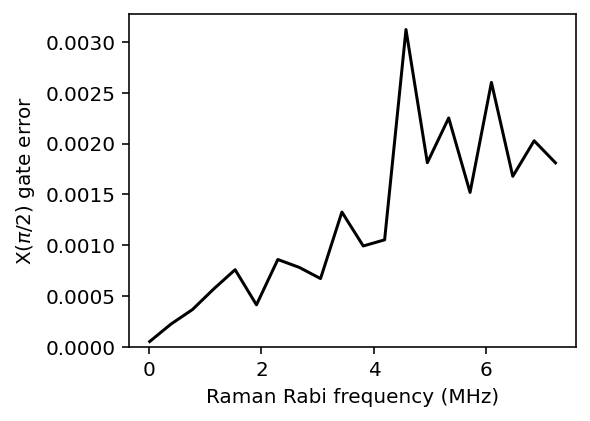

In [71]:
plt.figure(dpi=144, figsize=(4,3))

plt.plot(np.array(f_ls)/1e6, xrot_err_ls, 'k-')
plt.xlabel('Raman Rabi frequency (MHz)')
plt.ylabel('X($\pi$/2) gate error')
plt.ylim(0,)

## As a function of B field

In [72]:
Delta_12 = 2*np.pi*2.2e9 #detuning from the free space resonance of F=1/2
Delta_32 = Delta_12-2*np.pi*6e9 #detuning from the free space resonance of F=3/2

In [82]:
phi = np.pi/2

#total intensity at the atom
wV = 0.055e-3
wH = 1.3e-3
Ptot = 562e-3
intensity = 2*Ptot/np.pi/wV/wH

f_ls = []

output_ls = []

ttot_ls = []

xrot_err_ls = []

B_ls = np.linspace(0, 4.8, 100)*6.8*1e-4

for B in B_ls:
    
    #Zeeman shifts

    gJe = 3/2 + (Se*(Se+1) - Le*(Le+1)) / 2 / Je / (Je+1)  
    gFe_12 = (Fe_12*(Fe_12+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_12 / (Fe_12+1) * gJe
    gFe_32 = (Fe_32*(Fe_32+1) + Je*(Je+1) - I*(I+1)) / 2 / Fe_32 / (Fe_32+1) * gJe


    delta_N = -2*np.pi*750*B #nuclear states splitting

    Delta_g1 = -delta_N/2
    Delta_g2 = delta_N/2

    Delta_e3 = -1/2*gFe_12*mB*B / hbar
    Delta_e4 = 1/2*gFe_12*mB*B / hbar
    Delta_e5 = -3/2*gFe_32*mB*B / hbar
    Delta_e6 = -1/2*gFe_32*mB*B / hbar
    Delta_e7 = 1/2*gFe_32*mB*B / hbar
    Delta_e8 = 3/2*gFe_32*mB*B / hbar
    
    #diagonal terms
    diag_1 = Delta_g1
    diag_2 = Delta_g2

    diag_3 = -Delta_12 + Delta_e3
    diag_4 = -Delta_12 + Delta_e4

    diag_5 = -Delta_32 + Delta_e5
    diag_6 = -Delta_32 + Delta_e6
    diag_7 = -Delta_32 + Delta_e7
    diag_8 = -Delta_32 + Delta_e8
    

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = 1/np.sqrt(2)*(y+np.exp(-1j*phi)*z)

    #spherical tensor
    pi_pol = y
    sigp_pol = 1/np.sqrt(2)*(z-1j*x)
    sigm_pol = -1/np.sqrt(2)*(z+1j*x)
    
    #off-diagonal terms
    offdiag_31 = Rabi(Fg, Fe_12, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_41 = Rabi(Fg, Fe_12, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    offdiag_32 = Rabi(Fg, Fe_12, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_42 = Rabi(Fg, Fe_12, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2

    offdiag_51 = Rabi(Fg, Fe_32, -1/2, -3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_61 = Rabi(Fg, Fe_32, -1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_71 = Rabi(Fg, Fe_32, -1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2
    
    offdiag_62 = Rabi(Fg, Fe_32, 1/2, -1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigm_pol)) / 2
    offdiag_72 = Rabi(Fg, Fe_32, 1/2, 1/2, Jg, Je, I, omega_0, tau, np.dot(polarization, pi_pol)) / 2
    offdiag_82 = Rabi(Fg, Fe_32, 1/2, 3/2, Jg, Je, I, omega_0, tau, np.dot(polarization, sigp_pol)) / 2

    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_14 = np.conjugate(offdiag_41)
    offdiag_23 = np.conjugate(offdiag_32)
    offdiag_24 = np.conjugate(offdiag_42)

    offdiag_15 = np.conjugate(offdiag_51)
    offdiag_16 = np.conjugate(offdiag_61)
    offdiag_17 = np.conjugate(offdiag_71)
    
    offdiag_26 = np.conjugate(offdiag_62)
    offdiag_27 = np.conjugate(offdiag_72)
    offdiag_28 = np.conjugate(offdiag_82)

    Hdiag = (diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44 
             + diag_5*sig_55 + diag_6*sig_66 + diag_7*sig_77 + diag_8*sig_88)
    
    Hoffdiag = (    offdiag_13*sig_13 + offdiag_31*sig_31
                  + offdiag_14*sig_14 + offdiag_41*sig_41
    
                  + offdiag_23*sig_23 + offdiag_32*sig_32
                  + offdiag_24*sig_24 + offdiag_42*sig_42
    
                  + offdiag_15*sig_15 + offdiag_51*sig_51
                  + offdiag_16*sig_16 + offdiag_61*sig_61
                  + offdiag_17*sig_17 + offdiag_71*sig_71
    
                  + offdiag_62*sig_62 + offdiag_26*sig_26
                  + offdiag_72*sig_72 + offdiag_27*sig_27
                  + offdiag_82*sig_82 + offdiag_28*sig_28 )

    H = Hdiag + Hoffdiag
    guess=np.sqrt((abs(offdiag_31*offdiag_41)*np.sin(phi)/Delta_12)**2)
    c_ops = []
    
    options = qutip.solver.Options(nsteps=1000000)
    m=1000
    tf = 1./guess
    dt = tf/m
    t_ls = np.arange(0, tf, dt)
    
    ttot_ls.append(t_ls)
    
    output = mesolve(H, psi0, t_ls, c_ops, [sig_11], options=options)
    output_ls.append(output)
    
    popt, pcov = curve_fit(cos_fit, t_ls, output.expect[0], p0=[guess, -np.pi/2])
    
    f_ls.append(popt[0])
    
    xrot_err_ls.append(1-max(output.expect[0]))

(0.0, 0.003213848066978514)

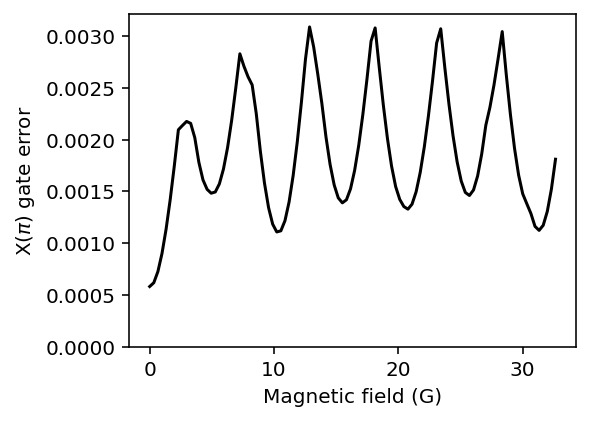

In [83]:
plt.figure(dpi=144, figsize=(4,3))

plt.plot(np.array(B_ls)*1e4, xrot_err_ls, 'k-')
plt.xlabel('Magnetic field (G)')
plt.ylabel('X($\pi$) gate error')
plt.ylim(0,)

Text(0, 0.5, 'Rabi MHz')

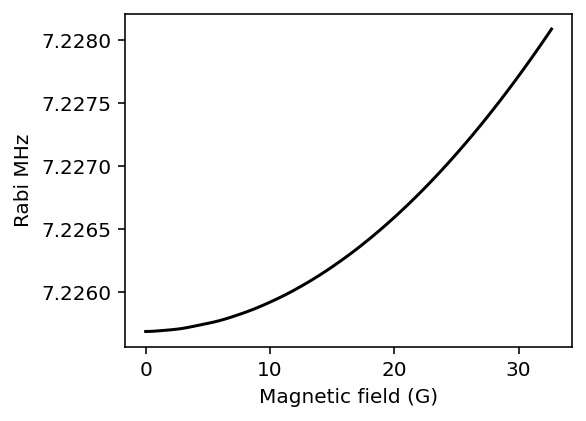

In [89]:
plt.figure(dpi=144, figsize=(4,3))

plt.plot(np.array(B_ls)*1e4, np.array(f_ls)/1e6, 'k-')
plt.xlabel('Magnetic field (G)')
plt.ylabel('Rabi MHz')